# Task 1: [Where's Waldo?](https://www.wikihow.com/Find-Waldo) (50%)

## Fingerprinting
Browser fingerprinting is a technique used to identify and track individuals based on unique characteristics of their web browser configuration. These characteristics can include the browser type, version, installed plugins, and screen resolution, among others. By combining these attributes, websites can create a digital fingerprint that can be used to track user behavior across multiple sites, even if they clear their cookies or use different devices. This has raised concerns about privacy and the potential for this technology to be used for targeted advertising, surveillance, and other purposes.

[Read more about Fingerprinting](https://datadome.co/learning-center/browser-fingerprinting-techniques/)


## What You Need to Do
In this task, you are required to employ a fully connected feed-forward Artificial Neural Network (ANN) to tackle a classification problem. This involves several key steps, each critical to the development and performance of your model:

- **Exploratory Data Analysis (EDA) (10%)**: Begin by conducting a thorough exploratory analysis of the provided dataset. Your goal here is to uncover patterns, anomalies, relationships, or trends that could influence your modeling decisions. **Share the insights** you gather from this process and explain how they informed your subsequent steps.
  
- **Data Preprocessing and Feature Engineering (10%)**: Based on your EDA insights, choose and implement the most appropriate data preprocessing steps and feature engineering techniques. This may include handling missing values, encoding categorical variables, normalizing data, and creating new features that could enhance your model's ability to learn from the data.
  
- **Model Design and Training (10%)**: Design a fully connected feed-forward ANN model. You will need to experiment with different architectures, layer configurations, and hyperparameters to find the most effective solution for the classification problem at hand.

- **Feature Importance Analysis (10%)**: After developing your model, analyze which features are most important for making predictions. Discuss how this analysis aligns with your initial EDA insights and what it reveals about the characteristics most indicative of specific user behaviors or identities.

- **Evaluation (10%)**: You will be required to submit your model prediction on a hidden data set.

### Data
You will be using the data in `Task_1.json` to identify Waldo (`user_id=0`). The dataset includes:
- **"browser", "os" and "locale"**: Information about the software used.
- **"user_id"**: A unique identifier for each user.
- **"location"**: Geolocation based on the IP address used.
- **"sites"**: A list of visited URLs and the time spent there in seconds.
- **"time" and "date"**: When the session started in GMT.


### Evaluation
After training, evaluate your model by printing the classification report on your test set. Then, predict whether each user in `task_1_verify.json` is Waldo or not, by adding the boolean `is_waldo` property to the `task_1_verify.json`:

```diff
  [
    {
+     "is_waldo": false,
      "browser": "Chrome",
      "os": "Debian",
      "locale": "ur-PK",
      "location": "Russia/Moscow",
      "sites": [
          // ...
      ],
      "time": "04:12:00",
      "date":"2017-06-29"
    }
    // ...
  ]

```

## Learning Objectives

- **Exploratory Data Analysis**: Apply suitable analysis techniques to gain insights and better understand the dataset.
- **Classification Approach**: Identify the most appropriate method for the given problem.
- **Data Preprocessing**: Select and execute proper preprocessing and encoding techniques.
- **Model Implementation**: Utilize ANNs to address a classification problem, including training, validation, and testing phases.
- **Feature Importance Analysis**: Determine and report which features are most critical for the model's predictions to uncover insights into specific user behaviors.

In [1]:
import numpy as np
import torch
import json
import pandas as pd

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Device: {device}, {use_cuda}")

import random

random_state = 100
np.random.seed(random_state)
random.seed(random_state)
torch.manual_seed(random_state)

Device: cuda, True


# 1. Exploratory Data Analysis

In [2]:
# load from task_1_train_data.json

with open('task_1_train_data.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

with open('task_1_verify.json') as f:
    test_data = json.load(f)

test_df = pd.DataFrame(test_data)

df.head(10)

,browser,os,locale,user_id,location,sites,time,date
0,Chrome,Debian,ur-PK,116,Russia/Moscow,"[{'site': 'bing.net', 'length': 52}, {'site': ...",04:12:00,2017-06-29
1,Firefox,Windows 8,uk-UA,155,France/Paris,"[{'site': 'yahoo.com', 'length': 46}, {'site':...",03:57:00,2016-03-23
2,Safari,MacOS,fr-FR,39,Japan/Tokyo,"[{'site': 'oracle.com', 'length': 335}]",05:26:00,2016-11-17
3,Chrome,Windows 8,nl-NL,175,Australia/Sydney,"[{'site': 'mail.google.com', 'length': 192}, {...",00:05:00,2016-08-23
4,Firefox,Ubuntu,ro-RO,50,USA/San Francisco,"[{'site': 'mail.google.com', 'length': 266}, {...",22:55:00,2016-07-23
5,Firefox,Windows 8,en-US,43,Canada/Vancouver,"[{'site': 'toptal.com', 'length': 57}, {'site'...",15:05:00,2016-08-11
6,Firefox,Windows 8,ur-PK,36,UK/London,"[{'site': 'bing.com', 'length': 92}]",07:25:00,2017-05-31
7,Safari,MacOS,nl-NL,197,Canada/Toronto,"[{'site': 'slack.com', 'length': 150}, {'site'...",03:26:00,2017-01-05
8,Safari,MacOS,en-NZ,135,Malaysia/Kuala Lumpur,"[{'site': 'youtube.com', 'length': 311}, {'sit...",05:11:00,2016-09-28
9,Chrome,Windows 8,vi-VN,93,USA/Miami,"[{'site': 'mail.google.com', 'length': 102}, {...",00:25:00,2017-08-28


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   browser   40000 non-null  object
 1   os        40000 non-null  object
 2   locale    40000 non-null  object
 3   user_id   40000 non-null  int64 
 4   location  40000 non-null  object
 5   sites     40000 non-null  object
 6   time      40000 non-null  object
 7   date      40000 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.4+ MB


In [4]:
df.describe()

,user_id
count,40000.000000
mean,99.500000
std,57.735027
min,0.000000
25%,49.750000
50%,99.500000
75%,149.250000
max,199.000000


### Count percentage of all classes in the train dataset.
We can see, each class, including Waldo, appear in the dataset for 0.005%.
In terms of binary classification problem for Waldo and non-Waldo classes, the dataset is unbalanced.

In [5]:
# count percentage of Waldo and non-Waldo users
new_df = df['user_id'].value_counts(normalize=True)
new_df = new_df.sort_index()
new_df

user_id
0      0.005
1      0.005
2      0.005
3      0.005
4      0.005
       ...  
195    0.005
196    0.005
197    0.005
198    0.005
199    0.005
Name: proportion, Length: 200, dtype: float64

In [6]:
# take a look at the sites and user_id
df[['user_id', 'sites']].head(20)

,user_id,sites
0,116,"[{'site': 'bing.net', 'length': 52}, {'site': ..."
1,155,"[{'site': 'yahoo.com', 'length': 46}, {'site':..."
2,39,"[{'site': 'oracle.com', 'length': 335}]"
3,175,"[{'site': 'mail.google.com', 'length': 192}, {..."
4,50,"[{'site': 'mail.google.com', 'length': 266}, {..."
5,43,"[{'site': 'toptal.com', 'length': 57}, {'site'..."
6,36,"[{'site': 'bing.com', 'length': 92}]"
7,197,"[{'site': 'slack.com', 'length': 150}, {'site'..."
8,135,"[{'site': 'youtube.com', 'length': 311}, {'sit..."
9,93,"[{'site': 'mail.google.com', 'length': 102}, {..."


### 'Time' column in the dataset is provided in GMT. We can assume, that local time, based on the location, will provide us with more usefully information and feature for training the model rather than raw time. Let us check for patterns in both time columns.

In [7]:
# find unique locations
countries = df['location'].unique()
print(countries)


['Russia/Moscow' 'France/Paris' 'Japan/Tokyo' 'Australia/Sydney'
 'USA/San Francisco' 'Canada/Vancouver' 'UK/London' 'Canada/Toronto'
 'Malaysia/Kuala Lumpur' 'USA/Miami' 'Italy/Rome' 'Spain/Madrid'
 'USA/Chicago' 'Germany/Berlin' 'China/Shanghai' 'India/Delhi'
 'Brazil/Rio de Janeiro' 'Singapore/Singapore' 'Netherlands/Amsterdam'
 'USA/New York' 'New Zealand/Auckland']


In [8]:
from datetime import datetime
import pytz

timezone_mapping = {
    'Russia/Moscow': 'Europe/Moscow',
    'France/Paris': 'Europe/Paris',
    'Japan/Tokyo': 'Asia/Tokyo',
    'Australia/Sydney': 'Australia/Sydney',
    'USA/San Francisco': 'America/Los_Angeles',
    'Canada/Vancouver': 'America/Vancouver',
    'UK/London': 'Europe/London',
    'Canada/Toronto': 'America/Toronto',
    'Malaysia/Kuala Lumpur': 'Asia/Kuala_Lumpur',
    'USA/Miami': 'America/New_York',
    'Italy/Rome': 'Europe/Rome',
    'Spain/Madrid': 'Europe/Madrid',
    'USA/Chicago': 'America/Chicago',
    'Germany/Berlin': 'Europe/Berlin',
    'China/Shanghai': 'Asia/Shanghai',
    'India/Delhi': 'Asia/Kolkata',
    'Brazil/Rio de Janeiro': 'America/Sao_Paulo',
    'Singapore/Singapore': 'Asia/Singapore',
    'Netherlands/Amsterdam': 'Europe/Amsterdam',
    'USA/New York': 'America/New_York',
    'New Zealand/Auckland': 'Pacific/Auckland'
}


def get_local_time(location, time):
    timezone = timezone_mapping.get(location)
    if timezone:
        date_time = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
        timezone = pytz.timezone(timezone)
        localized_date_time = timezone.localize(date_time)
        return localized_date_time
    return None


time1 = '2017-06-29 04:12:00'

print(get_local_time('USA/Miami', time1))

2017-06-29 04:12:00-04:00


In [9]:
# add a local_time column to the dataframe
df['local_time'] = df.apply(lambda x: get_local_time(x['location'], f"{x['date']} {x['time']}"), axis=1)
test_df['local_time'] = test_df.apply(lambda x: get_local_time(x['location'], f"{x['date']} {x['time']}"), axis=1)
df.head(20)


,browser,os,locale,user_id,location,sites,time,date,local_time
0,Chrome,Debian,ur-PK,116,Russia/Moscow,"[{'site': 'bing.net', 'length': 52}, {'site': ...",04:12:00,2017-06-29,2017-06-29 04:12:00+03:00
1,Firefox,Windows 8,uk-UA,155,France/Paris,"[{'site': 'yahoo.com', 'length': 46}, {'site':...",03:57:00,2016-03-23,2016-03-23 03:57:00+01:00
2,Safari,MacOS,fr-FR,39,Japan/Tokyo,"[{'site': 'oracle.com', 'length': 335}]",05:26:00,2016-11-17,2016-11-17 05:26:00+09:00
3,Chrome,Windows 8,nl-NL,175,Australia/Sydney,"[{'site': 'mail.google.com', 'length': 192}, {...",00:05:00,2016-08-23,2016-08-23 00:05:00+10:00
4,Firefox,Ubuntu,ro-RO,50,USA/San Francisco,"[{'site': 'mail.google.com', 'length': 266}, {...",22:55:00,2016-07-23,2016-07-23 22:55:00-07:00
5,Firefox,Windows 8,en-US,43,Canada/Vancouver,"[{'site': 'toptal.com', 'length': 57}, {'site'...",15:05:00,2016-08-11,2016-08-11 15:05:00-07:00
6,Firefox,Windows 8,ur-PK,36,UK/London,"[{'site': 'bing.com', 'length': 92}]",07:25:00,2017-05-31,2017-05-31 07:25:00+01:00
7,Safari,MacOS,nl-NL,197,Canada/Toronto,"[{'site': 'slack.com', 'length': 150}, {'site'...",03:26:00,2017-01-05,2017-01-05 03:26:00-05:00
8,Safari,MacOS,en-NZ,135,Malaysia/Kuala Lumpur,"[{'site': 'youtube.com', 'length': 311}, {'sit...",05:11:00,2016-09-28,2016-09-28 05:11:00+08:00
9,Chrome,Windows 8,vi-VN,93,USA/Miami,"[{'site': 'mail.google.com', 'length': 102}, {...",00:25:00,2017-08-28,2017-08-28 00:25:00-04:00


In [10]:
# show rows with local_time is None
df[df['local_time'].isnull()]


,browser,os,locale,user_id,location,sites,time,date,local_time


In [11]:
# leave o
print(type(df['local_time'][0]))
# convert the local_time column to datetime
# ValueError: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True, at position 1
df['local_time'] = pd.to_datetime(df['local_time'], utc=True)
test_df['local_time'] = pd.to_datetime(test_df['local_time'], utc=True)

print(type(df['local_time'][0]))

<class 'datetime.datetime'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


C:\Users\sasha\AppData\Local\Temp\ipykernel_20292\2107638404.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waldo_df['local_time'] = waldo_df['local_time'].dt.hour
C:\Users\sasha\AppData\Local\Temp\ipykernel_20292\2107638404.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  waldo_df['time'] = pd.to_datetime(waldo_df['time'])
C:\Users\sasha\AppData\Local\Temp\ipykernel_20292\2107638404.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

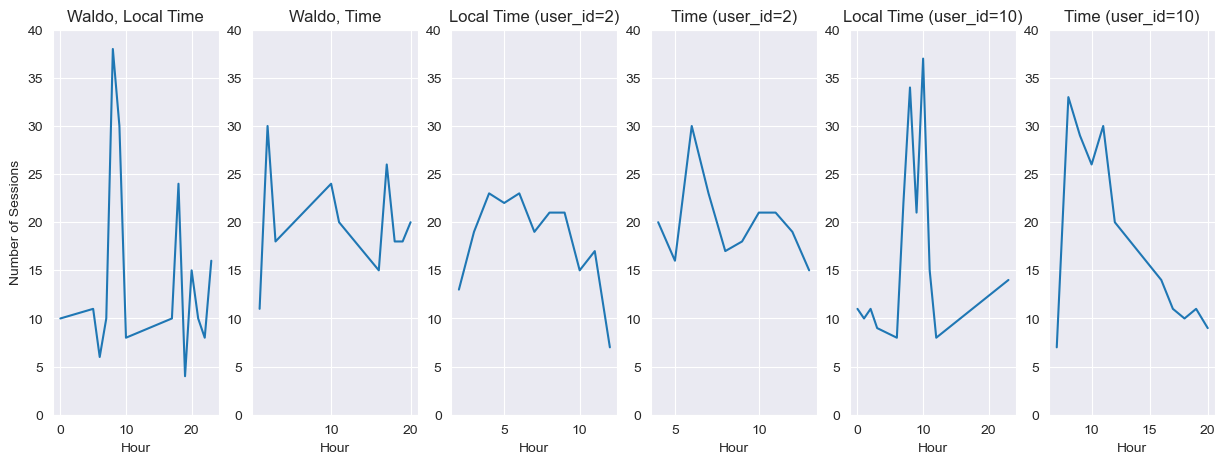

In [12]:
# wor waldo user_id = 0, plot the time of day when the user is active on local time and time
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 6, figsize=(15, 5))

waldo_df = df[df['user_id'] == 0]
not_waldo_df1 = df[df['user_id'] == 2]
not_waldo_df2 = df[df['user_id'] == 10]

# count avera
waldo_df['local_time'] = waldo_df['local_time'].dt.hour
ax[0].plot(waldo_df['local_time'].value_counts().sort_index())
# plot average number of sessions per user for all other users

ax[0].set_title('Waldo, Local Time')
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Number of Sessions')
ax[0].set_ylim(0, 40)

waldo_df['time'] = pd.to_datetime(waldo_df['time'])
waldo_df['time'] = waldo_df['time'].dt.hour
ax[1].plot(waldo_df['time'].value_counts().sort_index())
ax[1].set_title('Waldo, Time')
ax[1].set_xlabel('Hour')
ax[1].set_ylim(0, 40)

not_waldo_df1['local_time'] = not_waldo_df1['local_time'].dt.hour
times = not_waldo_df1['local_time'].value_counts().sort_index()
times = times / not_waldo_df1['user_id'].nunique()
ax[2].plot(times)
ax[2].set_title('Local Time (user_id=2)')
ax[2].set_xlabel('Hour')
ax[2].set_ylim(0, 40)

not_waldo_df1['time'] = pd.to_datetime(not_waldo_df1['time'])
not_waldo_df1['time'] = not_waldo_df1['time'].dt.hour
times = not_waldo_df1['time'].value_counts().sort_index()
times = times / not_waldo_df1['user_id'].nunique()
ax[3].plot(times)
ax[3].set_title('Time (user_id=2)')
ax[3].set_xlabel('Hour')
ax[3].set_ylim(0, 40)

not_waldo_df2['local_time'] = not_waldo_df2['local_time'].dt.hour
# plot average number of sessions per user for all other users
times = not_waldo_df2['local_time'].value_counts().sort_index()
# divide by the number of users
times = times / not_waldo_df2['user_id'].nunique()
ax[4].plot(times)
ax[4].set_title('Local Time (user_id=10)')
ax[4].set_xlabel('Hour')
ax[4].set_ylim(0, 40)

not_waldo_df2['time'] = pd.to_datetime(not_waldo_df2['time'])
not_waldo_df2['time'] = not_waldo_df2['time'].dt.hour
times = not_waldo_df2['time'].value_counts().sort_index()
times = times / not_waldo_df2['user_id'].nunique()
ax[5].plot(times)
ax[5].set_title('Time (user_id=10)')
ax[5].set_xlabel('Hour')
ax[5].set_ylim(0, 40)

plt.show()

### We can notice, that while there is no obvious pattern in column 'time', users appear to have unique 'local_time' patterns, which can be seen as 'spikes', or in other words, time, then user tends to be the most active. This observation can be useful to choose local time as a feature instead of usual time.

# 2. Data Preprocessing and Feature Engineering

By experimenting with different preprocessing techniques, it was found, that month and hour are very important features. Before they were encoded with OneHotEncoder, they were in one of the 10 important features, while other time characteristics, such as day of the month or minutes appeared to be not significant.

In [13]:
# from date get  month
df['month'] = df['local_time'].dt.month_name()
test_df['month'] = test_df['local_time'].dt.month_name()
# leave only hours in local_time
df['local_time'] = df['local_time'].dt.hour
test_df['local_time'] = test_df['local_time'].dt.hour


In [14]:
df.head(5)

,browser,os,locale,user_id,location,sites,time,date,local_time,month
0,Chrome,Debian,ur-PK,116,Russia/Moscow,"[{'site': 'bing.net', 'length': 52}, {'site': ...",04:12:00,2017-06-29,1,June
1,Firefox,Windows 8,uk-UA,155,France/Paris,"[{'site': 'yahoo.com', 'length': 46}, {'site':...",03:57:00,2016-03-23,2,March
2,Safari,MacOS,fr-FR,39,Japan/Tokyo,"[{'site': 'oracle.com', 'length': 335}]",05:26:00,2016-11-17,20,November
3,Chrome,Windows 8,nl-NL,175,Australia/Sydney,"[{'site': 'mail.google.com', 'length': 192}, {...",00:05:00,2016-08-23,14,August
4,Firefox,Ubuntu,ro-RO,50,USA/San Francisco,"[{'site': 'mail.google.com', 'length': 266}, {...",22:55:00,2016-07-23,5,July


In [15]:
# drop time and date columns
df = df.drop(columns=['time', 'date'])
test_df = test_df.drop(columns=['time', 'date'])

### Let us explore the cites column by counting for each session the number of sites visited and total time spent

In [16]:
df['sites_count'] = df['sites'].apply(lambda x: len(x))
df['total_time'] = df['sites'].apply(lambda x: sum([site['length'] for site in x]))
test_df['sites_count'] = test_df['sites'].apply(lambda x: len(x))
test_df['total_time'] = test_df['sites'].apply(lambda x: sum([site['length'] for site in x]))
df[['user_id', 'sites_count', 'total_time']].head(10)

,user_id,sites_count,total_time
0,116,10,849
1,155,8,1201
2,39,1,335
3,175,3,505
4,50,8,1206
5,43,6,936
6,36,1,92
7,197,9,1159
8,135,12,1688
9,93,4,552


#### Since the task is to find Waldo specifically, we can try to focus on the most visited cites by Waldo in terms of total count, total and average time spend on each of visited sites.

In [17]:
waldo_sites = {}
waldo_df = df[df['user_id'] == 0]
for sites in waldo_df['sites']:
    for site in sites:
        if site['site'] in waldo_sites:
            waldo_sites[site['site']]['count'] += 1
            waldo_sites[site['site']]['total_time'] += site['length']
        else:
            waldo_sites[site['site']] = {'count': 1, 'total_time': site['length']}
    # calculate the average time spent on each site by Waldo
for site in waldo_sites:
    waldo_sites[site]['average_time'] = waldo_sites[site]['total_time'] / waldo_sites[site]['count']

print(f"Number of unique sites visited by Waldo: {len(waldo_sites)}")
print(f'Most visited site by Waldo: {max(waldo_sites, key=lambda x: waldo_sites[x]["count"])}')
print(f'Most time spent on site by Waldo: {max(waldo_sites, key=lambda x: waldo_sites[x]["total_time"])}')
# print top 10 sites visited by Waldo with count and total time spent
sorted_waldo_sites_count = sorted(waldo_sites.items(), key=lambda x: x[1]['count'], reverse=True)
print("--------------------")
print(f"Top 10 sites visited by Waldo with count and total time spent")
for site in sorted_waldo_sites_count[:10]:
    print(
        f"Site: {site[0]}, Count: {site[1]['count']}, Total Time: {site[1]['total_time']}, Average Time: {site[1]['average_time']}")
# top 10 sites with most time spent by Waldo
print("--------------------")
print(f"Top 10 sites with most time spent by Waldo")
sorted_waldo_sites_time = sorted(waldo_sites.items(), key=lambda x: x[1]['total_time'], reverse=True)
for site in sorted_waldo_sites_time[:10]:
    print(
        f"Site: {site[0]}, Count: {site[1]['count']}, Total Time: {site[1]['total_time']}, Average Time: {site[1]['average_time']}")

Number of unique sites visited by Waldo: 607
Most visited site by Waldo: lenta.ru
Most time spent on site by Waldo: lenta.ru
--------------------
Top 10 sites visited by Waldo with count and total time spent
Site: lenta.ru, Count: 182, Total Time: 26451, Average Time: 145.33516483516485
Site: toptal.com, Count: 179, Total Time: 23964, Average Time: 133.87709497206703
Site: vk.com, Count: 175, Total Time: 22475, Average Time: 128.42857142857142
Site: slack.com, Count: 173, Total Time: 23775, Average Time: 137.4277456647399
Site: mail.google.com, Count: 170, Total Time: 22500, Average Time: 132.35294117647058
Site: youtube.com, Count: 170, Total Time: 22263, Average Time: 130.95882352941177
Site: france-pari.fr, Count: 2, Total Time: 192, Average Time: 96.0
Site: doctrine-project.org, Count: 2, Total Time: 435, Average Time: 217.5
Site: univ-paris13.fr, Count: 2, Total Time: 207, Average Time: 103.5
Site: imagehotel.net, Count: 2, Total Time: 258, Average Time: 129.0
--------------------

We can choose the top 50 sites visited by Waldo and add them as columns to the dataframe. 50 most visited by Waldo by total count were chosen and encoded into the columns with site name. If the site in a row was in the list of most popular Waldo sites, 1 was put in the corresponding column, otherwise 0 was put.


In [18]:
def get_site_names(sites):
    site_names = {}
    for site in sites:
        site_names[site['site']] = site['length']
    return site_names


for site in sorted_waldo_sites_count[:50]:
    df[site[0]] = df['sites'].apply(lambda x: 1 if site[0] in get_site_names(x) else 0)
    test_df[site[0]] = test_df['sites'].apply(lambda x: 1 if site[0] in get_site_names(x) else 0)


In [19]:
df.head(10)

,browser,os,locale,user_id,location,sites,local_time,month,sites_count,total_time,...,db.tt,sensagent.com,fun-mooc.fr,ekladata.com,buzzly.fr,freefaculty.org,machine-outil.com,onsefaitchier.com,archive-host.com,viki.io
0,Chrome,Debian,ur-PK,116,Russia/Moscow,"[{'site': 'bing.net', 'length': 52}, {'site': ...",1,June,10,849,...,0,0,0,0,0,0,0,0,0,0
1,Firefox,Windows 8,uk-UA,155,France/Paris,"[{'site': 'yahoo.com', 'length': 46}, {'site':...",2,March,8,1201,...,0,0,0,0,0,0,0,0,0,0
2,Safari,MacOS,fr-FR,39,Japan/Tokyo,"[{'site': 'oracle.com', 'length': 335}]",20,November,1,335,...,0,0,0,0,0,0,0,0,0,0
3,Chrome,Windows 8,nl-NL,175,Australia/Sydney,"[{'site': 'mail.google.com', 'length': 192}, {...",14,August,3,505,...,0,0,0,0,0,0,0,0,0,0
4,Firefox,Ubuntu,ro-RO,50,USA/San Francisco,"[{'site': 'mail.google.com', 'length': 266}, {...",5,July,8,1206,...,0,0,0,0,0,0,0,0,0,0
5,Firefox,Windows 8,en-US,43,Canada/Vancouver,"[{'site': 'toptal.com', 'length': 57}, {'site'...",22,August,6,936,...,0,0,0,0,0,0,0,0,0,0
6,Firefox,Windows 8,ur-PK,36,UK/London,"[{'site': 'bing.com', 'length': 92}]",6,May,1,92,...,0,0,0,0,0,0,0,0,0,0
7,Safari,MacOS,nl-NL,197,Canada/Toronto,"[{'site': 'slack.com', 'length': 150}, {'site'...",8,January,9,1159,...,0,0,0,0,0,0,0,0,0,0
8,Safari,MacOS,en-NZ,135,Malaysia/Kuala Lumpur,"[{'site': 'youtube.com', 'length': 311}, {'sit...",21,September,12,1688,...,0,0,0,0,0,0,0,0,0,0
9,Chrome,Windows 8,vi-VN,93,USA/Miami,"[{'site': 'mail.google.com', 'length': 102}, {...",4,August,4,552,...,0,0,0,0,0,0,0,0,0,0


### Now we need to check for remaining columns with 'object' type and decide, should we encode them or delete.

In [20]:
# output all object columns
df.select_dtypes(include=['object']).head(10)

,browser,os,locale,location,sites,month
0,Chrome,Debian,ur-PK,Russia/Moscow,"[{'site': 'bing.net', 'length': 52}, {'site': ...",June
1,Firefox,Windows 8,uk-UA,France/Paris,"[{'site': 'yahoo.com', 'length': 46}, {'site':...",March
2,Safari,MacOS,fr-FR,Japan/Tokyo,"[{'site': 'oracle.com', 'length': 335}]",November
3,Chrome,Windows 8,nl-NL,Australia/Sydney,"[{'site': 'mail.google.com', 'length': 192}, {...",August
4,Firefox,Ubuntu,ro-RO,USA/San Francisco,"[{'site': 'mail.google.com', 'length': 266}, {...",July
5,Firefox,Windows 8,en-US,Canada/Vancouver,"[{'site': 'toptal.com', 'length': 57}, {'site'...",August
6,Firefox,Windows 8,ur-PK,UK/London,"[{'site': 'bing.com', 'length': 92}]",May
7,Safari,MacOS,nl-NL,Canada/Toronto,"[{'site': 'slack.com', 'length': 150}, {'site'...",January
8,Safari,MacOS,en-NZ,Malaysia/Kuala Lumpur,"[{'site': 'youtube.com', 'length': 311}, {'sit...",September
9,Chrome,Windows 8,vi-VN,USA/Miami,"[{'site': 'mail.google.com', 'length': 102}, {...",August


### By experiment, it waws found, that model is showing enhanced performance with features encoded with OneHotEncoder. Theoretically, this behavior could be explained by arguing, that classification problems tend to classify better with more differentiation between features, since it will be easier for the model to put specific weights for each of the feature categories. 

In [21]:
from sklearn.preprocessing import OneHotEncoder


def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    # create dataframe from encoded features with named columns
    new_cols = pd.DataFrame(new_feats, columns=encoder.get_feature_names_out(features_name))
    new_df = pd.concat([df, new_cols], axis=1)
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df


# Create OneHotEncoder instance
ohe = OneHotEncoder(sparse_output=False)
names = ['browser', 'os', 'locale', 'location', 'local_time', 'month']

ohe.fit(df[names])
df = ohe_new_features(df, names, ohe)
test_df = ohe_new_features(test_df, names, ohe)

### Sites have been preprocessed, we no longer need this column.

In [22]:
df = df.drop(columns=[
    'sites',
])
test_df = test_df.drop(columns=['sites'])
# drop user_id column
df1 = df.drop(columns=['user_id'])

### Total time and sites count columns have shown a small, but significant improvement in the model, but only if they are scaled. It is important to make all the features in approximately the same range, that way the model will not prioritize some parameters over others.

In [23]:
# scale columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# scale local_time column and sites columns
# fit total_time and sites_count
df[['total_time', 'sites_count']] = scaler.fit_transform(df[['total_time', 'sites_count']])
test_df[['total_time', 'sites_count']] = scaler.transform(test_df[['total_time', 'sites_count']])


In [24]:
df.head(10)

,user_id,sites_count,total_time,lenta.ru,toptal.com,vk.com,slack.com,mail.google.com,youtube.com,france-pari.fr,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,116,0.769231,0.246373,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,155,0.615385,0.348520,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,39,0.076923,0.097214,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,175,0.230769,0.146547,0,0,0,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50,0.615385,0.349971,0,1,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,43,0.461538,0.271619,1,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,36,0.076923,0.026698,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,197,0.692308,0.336332,1,0,0,1,0,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,135,0.923077,0.489843,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,93,0.307692,0.160186,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# count number of unique user_id
df['user_id'].nunique()

200

In [26]:
# test_df.head()
# drop is_waldo column
test_df = test_df.drop(columns=['is_waldo'])

In [27]:
df.head()

,user_id,sites_count,total_time,lenta.ru,toptal.com,vk.com,slack.com,mail.google.com,youtube.com,france-pari.fr,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,116,0.769231,0.246373,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,155,0.615385,0.348520,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,39,0.076923,0.097214,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,175,0.230769,0.146547,0,0,0,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50,0.615385,0.349971,0,1,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Model Design and Training (10%)
## Multi-Layer Perceptron (MLP) Classifier with Scikit-Learn

In [28]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['user_id']).values
y = df['user_id'].values
# convert non-zero values to 1
y = [1 if i != 0 else 0 for i in y]
# change 1 to 0 and 0 to 1
# 0 - non-Waldo, 1 - Waldo
y = [0 if i == 1 else 1 for i in y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=250, random_state=42)

In [30]:
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=250, random_state=42)

In [31]:
# evaluate the model
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7960
           1       0.83      0.60      0.70        40

    accuracy                           1.00      8000
   macro avg       0.91      0.80      0.85      8000
weighted avg       1.00      1.00      1.00      8000


In [32]:
# print info about the model
print(model)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=250, random_state=42)


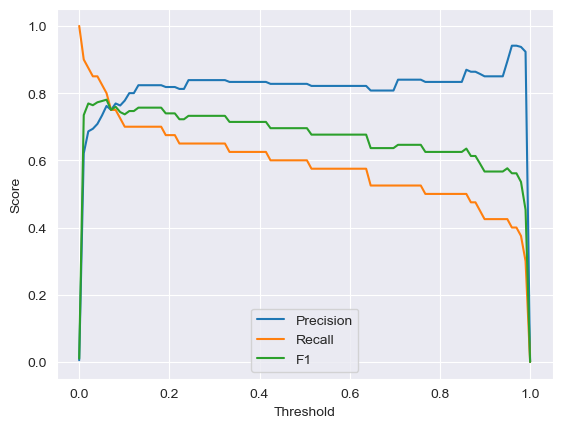

In [33]:
# define different thesholds for the model, then plot precision, recall and f1
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

thresholds = np.linspace(0, 1, 100)

precisions = []
recalls = []
f1s = []
for threshold in thresholds:
    y_pred = model.predict_proba(X_test)[:, 1] > threshold
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

Teh threshold value is chosen, when the difference between precision and recall is minimal to achieve the balance between them.

In [34]:
threshold_value = 0.25
for i in range(5, 80):
    if (abs(precisions[i] - recalls[i])) < 0.001:
        threshold_value = thresholds[i]
        break
# threshold_value = 0.59
print(f"Threshold value: {threshold_value}")

Threshold value: 0.07070707070707072


In [35]:
y_pred = model.predict_proba(X_test)[:, 1] > threshold_value
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7960
           1       0.75      0.75      0.75        40

    accuracy                           1.00      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       1.00      1.00      1.00      8000


In [36]:
X_val = test_df.values
y_val = model.predict_proba(X_val)[:, 1] > threshold_value
print(y_val)

[False False False ... False False False]


In [37]:
# count the percentage of Waldo and non-Waldo users with value_counts
print(pd.Series(y_val).value_counts())
print(pd.Series(y_val).value_counts(normalize=True))

False    39796
True       204
Name: count, dtype: int64
False    0.9949
True     0.0051
Name: proportion, dtype: float64


## Multi-Layer Perceptron (MLP) Classifier with PyTorch

Using the MLPClassifier as a prototype, we can implement the same model with PyTorch. The model will have an architecture close to MLPClassifier, with two hidden layers of 64 and 32 neurons, respectively. 

In [38]:
# implement the same model with pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [39]:
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
num_classes = 1

model_t = nn.Sequential(
    nn.Linear(input_size, hidden_size1),
    nn.ReLU(),
    nn.Linear(hidden_size1, hidden_size2),
    nn.ReLU(),
    nn.Linear(hidden_size2, num_classes),
    nn.Sigmoid()
).to(device)
print(model_t)

Sequential(
  (0): Linear(in_features=144, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)


In [40]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_t.parameters())
batch_size = 16

In [41]:
# convert the data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [42]:
# train the model
from tqdm import tqdm


def train(model, criterion, optimizer, X_train, y_train):
    model.train()
    bar = tqdm(range(100))
    for epoch in bar:
        # for i in range(100):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train.view(-1, 1))
        loss.backward()
        optimizer.step()
        bar.set_postfix({"Loss": loss.item()})
    train_losses.append(loss)



In [43]:
def test(model, X_test, y_test, epoch):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        loss = criterion(output, y_test.view(-1, 1))
        pred = output > 0.5
        pred = pred.cpu().numpy()
        y_test = y_test.cpu().numpy()
        if epoch % 5 == 0:
            precision = precision_score(y_test, pred, average='binary', pos_label=1, zero_division=0)
            recall = recall_score(y_test, pred, average='binary', pos_label=1, zero_division=0)
            f1 = f1_score(y_test, pred, average='binary', pos_label=1, zero_division=0)
            accuracy = accuracy_score(y_test, pred)

            print(
                f"Epoch {epoch}| Test set: Average loss: {loss}, F1: {f1}, Recall: {recall}, Precision: {precision}, Accuracy: {accuracy}\n ")
        test_losses.append(loss)

In [44]:
# train the model
# global iteration
# # iteration = 0
train_losses = []
test_losses = []
for epoch in range(1, 21):
    train(model_t, criterion, optimizer, X_train, y_train)
    test(model_t, X_test, y_test, epoch)

100%|██████████| 100/100 [00:00<00:00, 311.92it/s, Loss=0.00883]


Epoch 5| Test set: Average loss: 0.011174631305038929, F1: 0.0, Recall: 0.0, Precision: 0.0, Accuracy: 0.995
 


100%|██████████| 100/100 [00:00<00:00, 317.71it/s, Loss=0.00232]


Epoch 10| Test set: Average loss: 0.007305670529603958, F1: 0.6865671641791045, Recall: 0.575, Precision: 0.8518518518518519, Accuracy: 0.997375
 


100%|██████████| 100/100 [00:00<00:00, 349.55it/s, Loss=0.000983]


Epoch 15| Test set: Average loss: 0.008765678852796555, F1: 0.7671232876712328, Recall: 0.7, Precision: 0.8484848484848485, Accuracy: 0.997875
 


100%|██████████| 100/100 [00:00<00:00, 329.17it/s, Loss=0.000654]

Epoch 20| Test set: Average loss: 0.011140374466776848, F1: 0.75, Recall: 0.675, Precision: 0.84375, Accuracy: 0.99775
 


The plot of loss for train and test datasets is shown below. There might be a slight overfit, but the model is showing good results, and assuming that the test dataset is pretty close to the real data, the model is showing acceptable results.

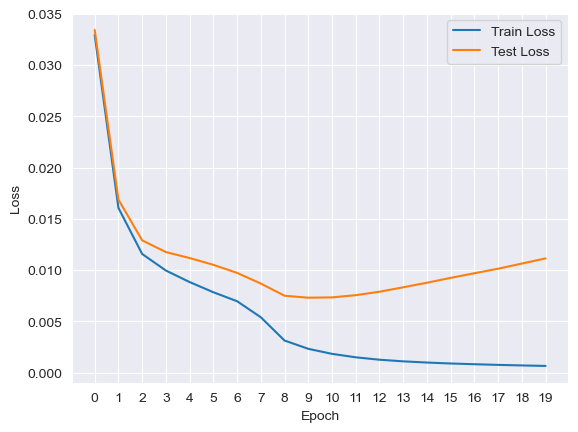

In [45]:
train_losses = [loss.cpu().detach().numpy() for loss in train_losses]
test_losses = [loss.cpu().detach().numpy() for loss in test_losses]

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# x grid with only integer values
plt.xticks(np.arange(0, 20, 1))
plt.legend()
plt.show()

Confusion matrix shows the number of True Positives, False Positives, True Negatives and False Negatives. The model is showing good results, with a high number of True Positives and True Negatives compared to False Positives and False Negatives. 

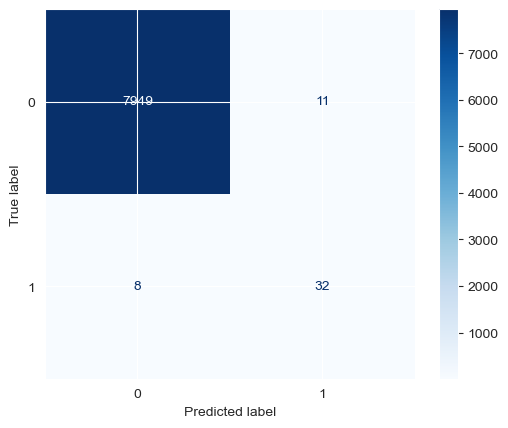

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

output = model_t(X_test)
pred = output > threshold_value
pred = pred.cpu().numpy()
y_test = y_test.cpu().numpy()
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')


In [47]:
X_val = test_df.values
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)

In [48]:
# predict the test data
model_t.eval()
with torch.no_grad():
    output = model_t(X_val)
    pred = output > threshold_value

    print(pred)

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]], device='cuda:0')


In [49]:
# count percentage of Waldo and non-Waldo users
pred = pred.cpu().numpy()
pred = pred.flatten()

print(pd.Series(pred).value_counts())
print(pd.Series(pred).value_counts(normalize=True))

False    39812
True       188
Name: count, dtype: int64
False    0.9953
True     0.0047
Name: proportion, dtype: float64


In [50]:
# save the results to the file task_1_verify.json
to_write = pd.Series(pred).apply(lambda x: True if x else False).to_list()
# put inside the is_waldo property
for i in range(len(test_data)):
    test_data[i]['is_waldo'] = to_write[i]

with open('task_1_verify.json', 'w') as f:
    json.dump(test_data, f)

In [51]:
# load from task_1_verify.json into df
with open('task_1_verify.json') as f:
    test_data = json.load(f)

test_df = pd.DataFrame(test_data)

test_df['is_waldo'].value_counts(normalize=True)


is_waldo
False    0.9953
True     0.0047
Name: proportion, dtype: float64

# 4. Feature Importance Analysis

In [52]:

weights1 = model.coefs_
weights2 = model_t[0].weight.data.cpu().numpy()
feature_names = df.drop(columns=['user_id']).columns

print(f"Number of weights: {weights1[0].shape[1]}, Number of features: {len(feature_names)}")
print(f"Number of weights: {weights2.shape[1]}, Number of features: {len(feature_names)}")


Number of weights: 64, Number of features: 144
Number of weights: 144, Number of features: 144


In [53]:
# calculate the feature importance
importances2 = np.abs(weights2).mean(axis=0)
importances1 = np.abs(weights1[0]).mean(axis=0)

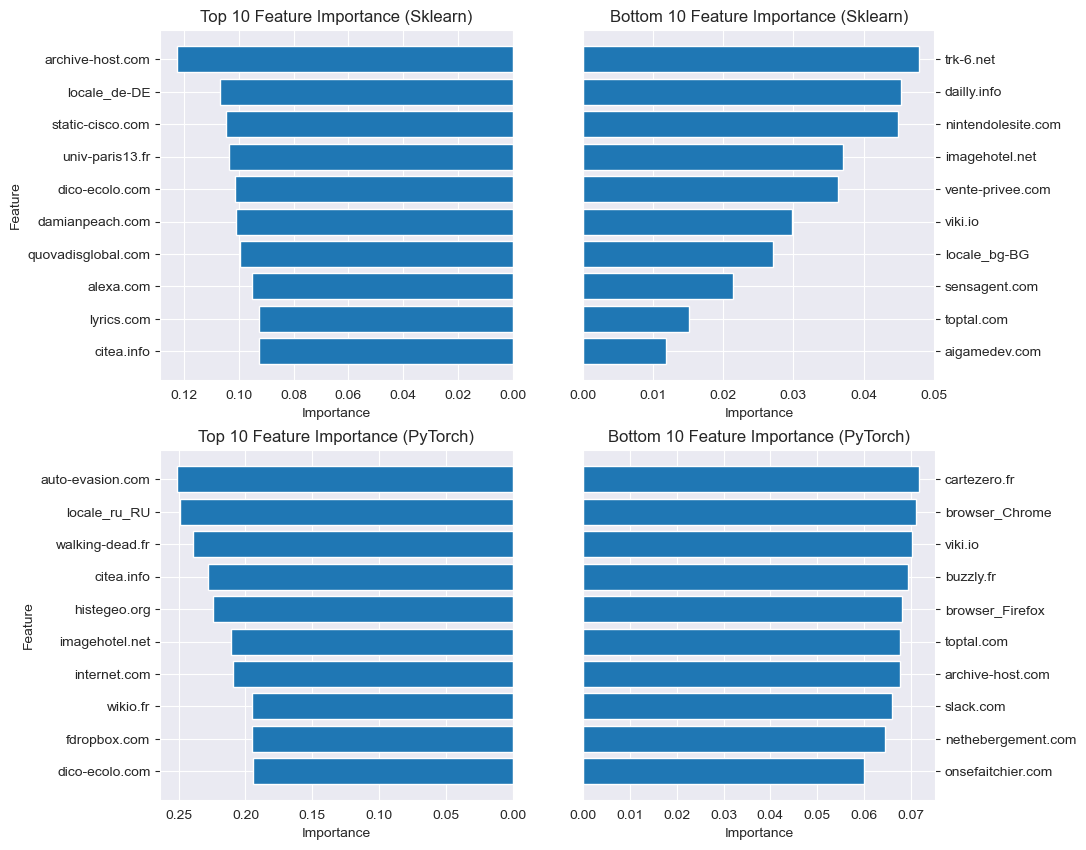

In [54]:
# make distance between horizontal plots wider
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
indices = np.argsort(importances1)
top_indices = indices[-10:]
top_importances = importances1[top_indices]
top_feature_names = feature_names[top_indices]

ax[0, 0].barh(top_feature_names, top_importances)
ax[0, 0].set_title('Top 10 Feature Importance (Sklearn)')
ax[0, 0].set_xlabel('Importance')
ax[0, 0].set_ylabel('Feature')
ax[0, 0].invert_xaxis()
ax[0, 0].yaxis.tick_left()

bottom_indices = indices[:10]
bottom_importances = importances1[bottom_indices]
bottom_feature_names = feature_names[bottom_indices]

ax[0, 1].barh(bottom_feature_names, bottom_importances)
ax[0, 1].set_title('Bottom 10 Feature Importance (Sklearn)')
ax[0, 1].set_xlabel('Importance')
ax[0, 1].yaxis.tick_right()

indices = np.argsort(importances2)
top_indices = indices[-10:]
top_importances = importances2[top_indices]
top_feature_names = feature_names[top_indices]

ax[1, 0].barh(top_feature_names, top_importances)
ax[1, 0].set_title('Top 10 Feature Importance (PyTorch)')
ax[1, 0].set_xlabel('Importance')
ax[1, 0].set_ylabel('Feature')
ax[1, 0].invert_xaxis()
ax[1, 0].yaxis.tick_left()

bottom_indices = indices[:10]
bottom_importances = importances2[bottom_indices]
bottom_feature_names = feature_names[bottom_indices]

ax[1, 1].barh(bottom_feature_names, bottom_importances)
ax[1, 1].set_title('Bottom 10 Feature Importance (PyTorch)')
ax[1, 1].set_xlabel('Importance')
ax[1, 1].yaxis.tick_right()

plt.show()

plt.show()

In both models, the most important features are different sites visited by Waldo, month and hour. The model trained with PyTorch shows a slightly different importance of features compared to the model trained with Sklearn. The difference in importance of features can be explained by the different optimization algorithms used in both models.

Interestingly, some features appeared in the list of most important features before the OneHotEncoder applied to them. For example, month column was initially in one of the top 10 important columns, but it was one hot encoded to improve f1, and it disappeared from the list of important features. 